Average optimistic bias E_out - E_val over K: 0.010
First few points (K, E_val, E_out):
  K= 10  E_val=0.237  E_out=0.260
  K= 20  E_val=0.236  E_out=0.262
  K= 30  E_val=0.245  E_out=0.262
  K= 40  E_val=0.247  E_out=0.262
  K= 50  E_val=0.247  E_out=0.263


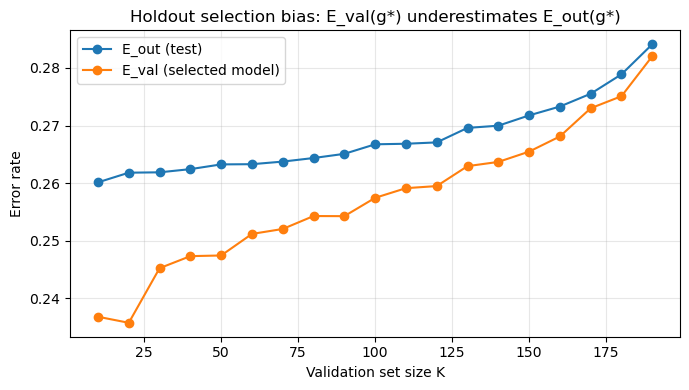

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

# ----- data-generating process (binary classification) -----
def _unit_w(d=5, rng=rng):
    w = rng.normal(size=d)
    w /= np.linalg.norm(w)
    return w

W_TRUE = _unit_w(5)

def make_data(n, d=5, noise=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    X = rng.normal(size=(n, d))
    y = ((X @ W_TRUE + rng.normal(scale=noise, size=n)) > 0).astype(int) * 2 - 1  # labels in {-1, +1}
    return X, y

# ----- models: linear vs quadratic features + ridge -----
def design_matrix(X, degree=1):
    n, d = X.shape
    out = [np.ones((n, 1)), X]  # intercept + linear
    if degree >= 2:
        for i in range(d):
            for j in range(i, d):
                out.append((X[:, i] * X[:, j])[:, None])  # squares & interactions
    return np.concatenate(out, axis=1)

def ridge_fit(Phi, y, lam):
    d = Phi.shape[1]
    I = np.eye(d); I[0, 0] = 0.0  # don't penalize intercept
    return np.linalg.solve(Phi.T @ Phi + lam * I, Phi.T @ y)

def cls_error(y_true, scores):
    pred = np.sign(scores)
    pred[pred == 0] = 1
    return np.mean(pred != y_true)

# ----- experiment -----
N = 240                      # total labeled examples
K_values = np.arange(10, 200, 10)  # validation sizes
R = 1000                      # Monte Carlo repetitions
N_test = 4000                # large test set to approximate E_out
degrees = [1, 2, 3, 4]
lams = [0] #np.logspace(-4, 2, 9)  # 12 total models: 2 deg × 6 lam (adjust as you like)

val_means = np.zeros_like(K_values, dtype=float)
out_means = np.zeros_like(K_values, dtype=float)

for rep in range(R):
    X_all, y_all = make_data(N, rng=np.random.default_rng(10_000 + rep))
    X_test, y_test = make_data(N_test, rng=np.random.default_rng(20_000 + rep))

    for i, K in enumerate(K_values):
        perm = rng.permutation(N)
        tr_idx, va_idx = perm[:N-K], perm[N-K:]
        Xtr, ytr = X_all[tr_idx], y_all[tr_idx]
        Xva, yva = X_all[va_idx], y_all[va_idx]

        best_val_err = np.inf
        best_deg, best_w = None, None

        # model selection on validation
        for deg in degrees:
            Phi_tr = design_matrix(Xtr, degree=deg)
            Phi_va = design_matrix(Xva, degree=deg)
            for lam in lams:
                w = ridge_fit(Phi_tr, ytr, lam)
                val_err = cls_error(yva, Phi_va @ w)
                if val_err < best_val_err:
                    best_val_err = val_err
                    best_deg, best_w = deg, w

        # unbiased estimate of E_out on fresh test data
        Phi_te = design_matrix(X_test, degree=best_deg)
        test_err = cls_error(y_test, Phi_te @ best_w)

        val_means[i] += best_val_err
        out_means[i] += test_err

val_means /= R
out_means /= R

# ----- report -----
print(f"Average optimistic bias E_out - E_val over K: {np.mean(out_means - val_means):.3f}")
print("First few points (K, E_val, E_out):")
for K, ev, eo in list(zip(K_values, val_means, out_means))[:5]:
    print(f"  K={K:3d}  E_val={ev:.3f}  E_out={eo:.3f}")

plt.figure(figsize=(7,4))
plt.plot(K_values, out_means, marker='o', label='E_out (test)')
plt.plot(K_values, val_means, marker='o', label='E_val (selected model)')
plt.xlabel('Validation set size K')
plt.ylabel('Error rate')
plt.title('Holdout selection bias: E_val(g*) underestimates E_out(g*)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
